# NLP CHALLENGE PIPELINE

## IMPORTS & SETUP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import re
import string
from collections import Counter

# Scikit-learn for ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# NLTK for text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


## DATA LOADING & EXPLORATION

In [2]:
"""
Load your data here. Common formats:
- CSV: pd.read_csv('data.csv')
"""
df = pd.read_csv('../dataset/data.csv')

# Basic exploration
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(f"Dataset shape: {df.shape}")
print(f"Dataset columns: {df.columns}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nDataset info:")
print(df.info())

print(f"\nMissing values:")
print(df.isnull().sum())

print(f"\nLabel distribution:")
print(df['label'].value_counts())


DATASET OVERVIEW
Dataset shape: (39942, 5)
Dataset columns: Index(['label', 'title', 'text', 'subject', 'date'], dtype='object')

First few rows:
   label                                              title  \
0      1  As U.S. budget fight looms, Republicans flip t...   
1      1  U.S. military to accept transgender recruits o...   
2      1  Senior U.S. Republican senator: 'Let Mr. Muell...   
3      1  FBI Russia probe helped by Australian diplomat...   
4      1  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  De

## TEXT PREPROCESSING

In [3]:
print("\n" + "="*50)
print("TEXT PREPROCESSING")
print("="*50)

class TextPreprocessor:
    """
    A class to handle all text preprocessing steps
    """
    
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
    
    def clean_text(self, text):
        """Basic cleaning: lowercase, remove punctuation & numbers"""
        text = text.lower()
        # Remove numbers and punctuation in one regex pass
        text = re.sub(r'[^a-z\s]', '', text)
        # remove words with less than 3 words
        text = re.sub(r"\b\w{1,2}\b", " ", text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def clean_text_alternative(self, text):
        """Alternative: Keep more control over what to remove"""
        text = text.lower()
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation (keeps underscores)
        text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
        return text
    
    def remove_stopwords(self, text):
        """Remove common stopwords using regex word boundaries"""
        # Create pattern with word boundaries for exact matches
        pattern = r'\b(' + '|'.join(self.stop_words) + r')\b'
        text = re.sub(pattern, '', text)
        # Clean up extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def remove_stopwords_split(self, text):
        """Alternative: Traditional split approach (often faster for small stopword lists)"""
        words = text.split()
        return ' '.join([w for w in words if w not in self.stop_words])
    
    def stem_text(self, text):
        """Apply stemming with regex tokenization"""
        # Use regex to split on whitespace
        words = re.findall(r'\b\w+\b', text)
        return ' '.join([self.stemmer.stem(w) for w in words])
    
    def lemmatize_text(self, text):
        """Apply lemmatization with regex tokenization"""
        # Use regex to extract words
        words = re.findall(r'\b\w+\b', text)
        return ' '.join([self.lemmatizer.lemmatize(w) for w in words])
    
    def preprocess(self, text, remove_stops=True, use_lemma=True, 
                   remove_urls=True, expand_contractions=True):
        """Complete preprocessing pipeline with optional advanced cleaning"""
        
        # Basic cleaning
        text = self.clean_text(text)
        
        # Stopword removal
        if remove_stops:
            text = self.remove_stopwords(text)
        
        # Stemming or Lemmatization
        if use_lemma:
            text = self.lemmatize_text(text)
        else:
            text = self.stem_text(text)
        
        return text

# Apply preprocessing
preprocessor = TextPreprocessor()
df['cleaned_text'] = df['title'] + ' ' + df['text']
df['cleaned_text'] = df['cleaned_text'].apply(preprocessor.preprocess)

print("\nExample of preprocessing:")
print(f"Original: {df['text'].iloc[0]}")
print(f"Cleaned:  {df['cleaned_text'].iloc[0]}")


TEXT PREPROCESSING

Example of preprocessing:
Original: WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense 

## EXPLORATORY DATA ANALYSIS


EXPLORATORY DATA ANALYSIS

Text statistics:
        text_length    word_count
count  39942.000000  39942.000000
mean    2384.637875    391.735867
std     1765.895463    286.378195
min        1.000000      0.000000
25%     1259.000000    207.000000
50%     2197.000000    363.500000
75%     3069.000000    506.000000
max    49705.000000   7033.000000

Top 10 most common words:
trump: 135636
said: 118439
state: 52952
president: 50193
would: 49880
republican: 38901
people: 36953
one: 32178
year: 30505
new: 28262


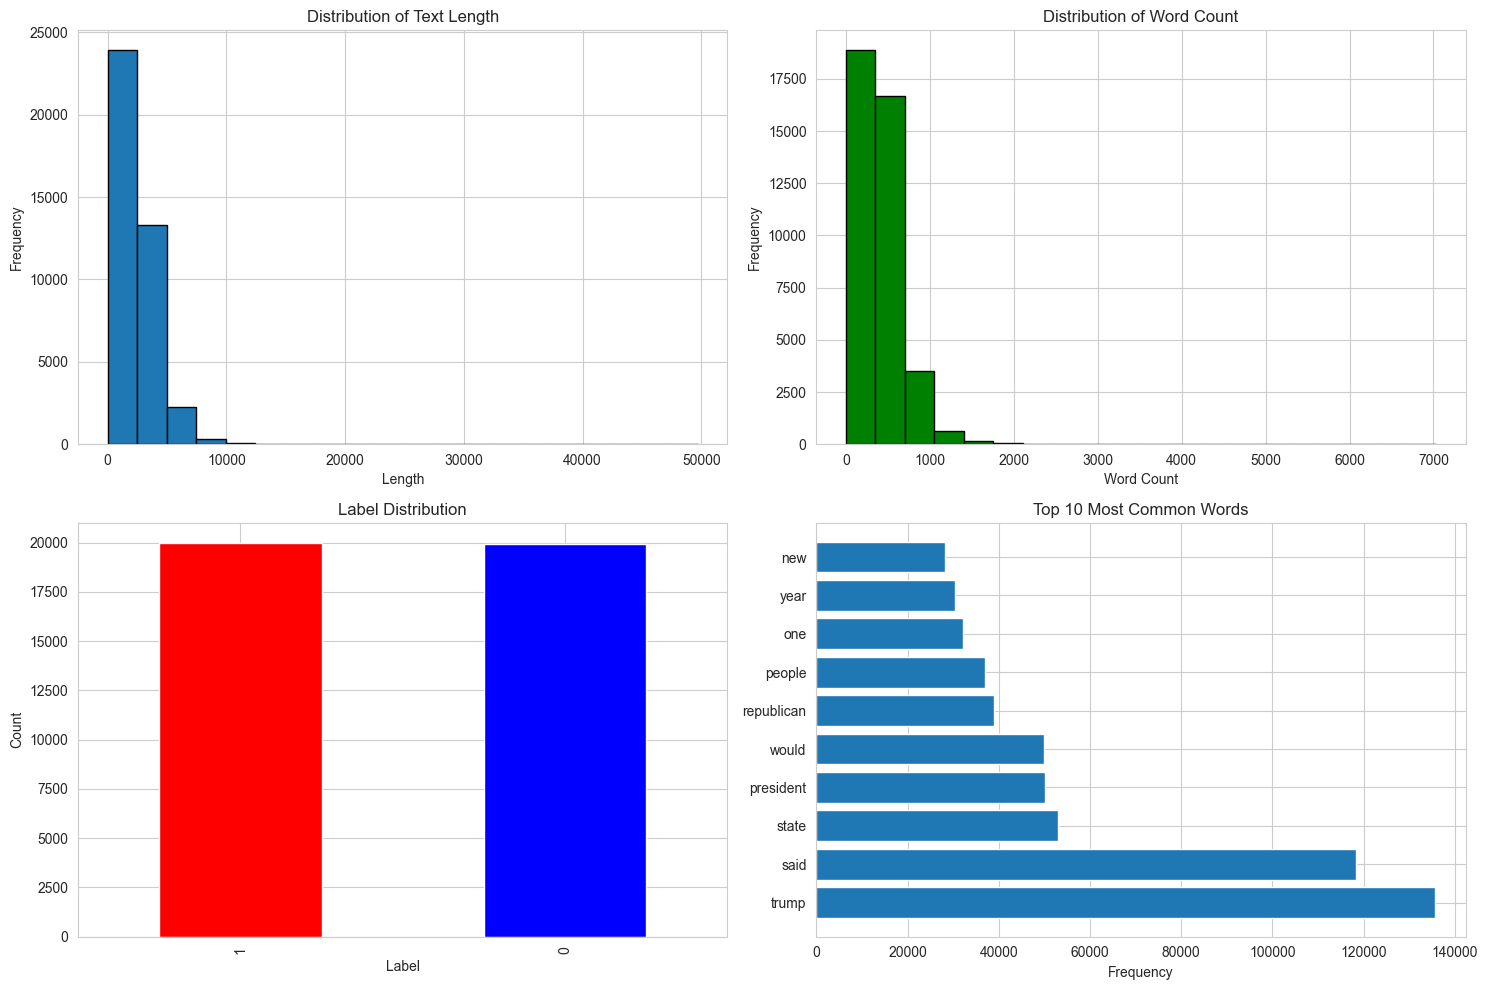

In [7]:
print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Text length analysis
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

print(f"\nText statistics:")
print(df[['text_length', 'word_count']].describe())

# Most common words
all_words = ' '.join(df['cleaned_text']).split()
word_freq = Counter(all_words)
print(f"\nTop 10 most common words:")
for word, count in word_freq.most_common(10):
    print(f"{word}: {count}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Text length distribution
axes[0, 0].hist(df['text_length'], bins=20, edgecolor='black')
axes[0, 0].set_title('Distribution of Text Length')
axes[0, 0].set_xlabel('Length')
axes[0, 0].set_ylabel('Frequency')

# Word count distribution
axes[0, 1].hist(df['word_count'], bins=20, edgecolor='black', color='green')
axes[0, 1].set_title('Distribution of Word Count')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')

# Label distribution
df['label'].value_counts().plot(kind='bar', ax=axes[1, 0], color=['red', 'blue'])
axes[1, 0].set_title('Label Distribution')
axes[1, 0].set_xlabel('Label')
axes[1, 0].set_ylabel('Count')

# Top words bar chart
top_words = dict(word_freq.most_common(10))
axes[1, 1].barh(list(top_words.keys()), list(top_words.values()))
axes[1, 1].set_title('Top 10 Most Common Words')
axes[1, 1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

Plot categories with their frequency applying hue (fake vs real). This dataset is obviously flawed

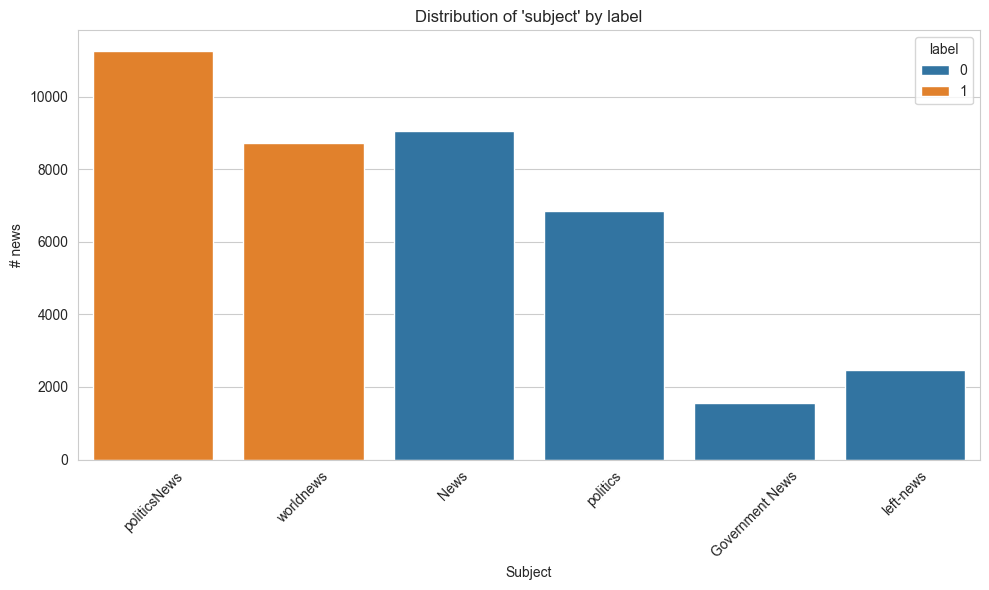

In [ ]:

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='subject', hue='label')
plt.title("Distribution of 'subject' by label")
plt.xlabel("Subject")
plt.ylabel("# news")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Stack the bar plot to verify that subject fake/real frequency is absolute

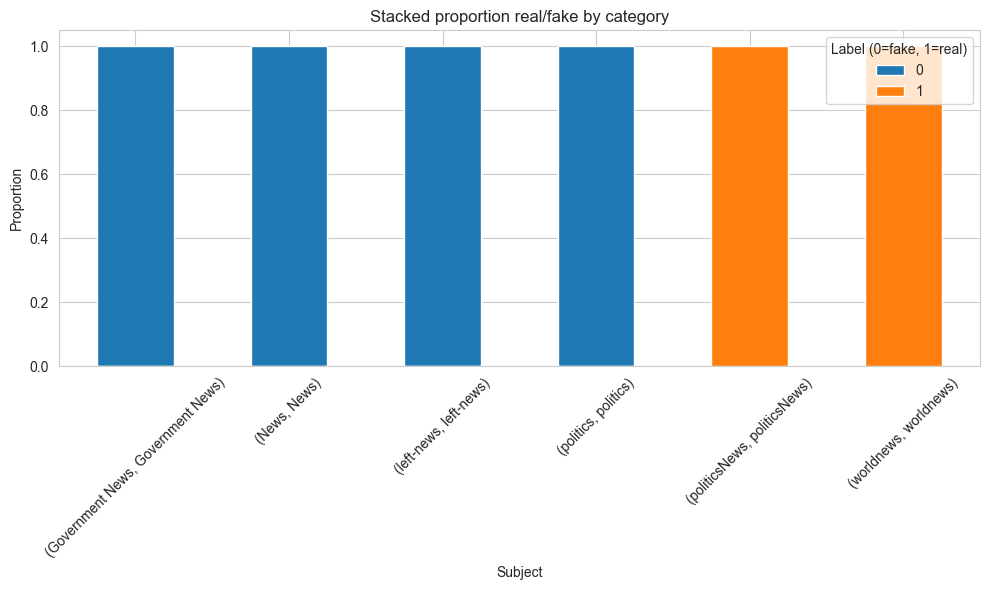

In [ ]:
prop = (
    df.groupby(['subject', 'label']).size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack(fill_value=0)
)

prop.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title("Stacked proportion real/fake by category")
plt.xlabel("Subject")
plt.ylabel("Proportion")
plt.legend(title="Label (0=fake, 1=real)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

After looking for information, some sites state that identifying balanced words are a good practice to get more real models

In [4]:
def get_balanced_vocabulary(df: pd.DataFrame, ratio_range: tuple = (0.5, 2.0), min_count: int = 10) -> list:
    """
    Gets the balanced words based on a ratio range
    """
    
    fake_texts = ' '.join(df[df['label']==0]['cleaned_text'].values)
    real_texts = ' '.join(df[df['label']==1]['cleaned_text'].values)
    
    fake_words = Counter(fake_texts.lower().split())
    real_words = Counter(real_texts.lower().split())
    
    balanced_words = []
    stats = {'too_fake': 0, 'too_real': 0, 'balanced': 0, 'too_rare': 0}
    
    # Words appearing in both fake and real
    common_words = set(fake_words.keys()) & set(real_words.keys())
    
    for word in common_words:
        fake_count = fake_words[word]
        real_count = real_words[word]
        
        # Filter too rare words
        if fake_count < min_count or real_count < min_count:
            stats['too_rare'] += 1
            continue
        
        # Calculate ratio
        ratio = fake_count / real_count if fake_count > real_count else real_count / fake_count
        
        if ratio_range[0] <= ratio <= ratio_range[1]:
            balanced_words.append(word)
            stats['balanced'] += 1
        elif fake_count > real_count:
            stats['too_fake'] += 1
        else:
            stats['too_real'] += 1
    
    print("="*60)
    print("Vocabulary analysis")
    print("="*60)
    print(f"Balanced: {stats['balanced']}")
    print(f"Biased FAKE: {stats['too_fake']}")
    print(f"Biased REAL: {stats['too_real']}")
    print(f"Barely appearing words: {stats['too_rare']}")
    
    # Examples
    print("Examples balanced words")
    for word in balanced_words[:10]:
        f_count = fake_words[word]
        r_count = real_words[word]
        print(f"  '{word}': fake={f_count}, real={r_count}")
    
    return balanced_words

balanced_vocab = get_balanced_vocabulary(df, ratio_range=(0.5, 2.2), min_count=8)

Vocabulary analysis
Balanced: 8557
Biased FAKE: 2990
Biased REAL: 2679
Barely appearing words: 20142
Examples balanced words
  'kellogg': fake=33, real=30
  'cost': fake=1610, real=2200
  'prohibiting': fake=36, real=58
  'element': fake=195, real=318
  'borne': fake=11, real=21
  'energetic': fake=16, real=14
  'stay': fake=985, real=1191
  'statelevel': fake=15, real=27
  'eighth': fake=46, real=50
  'solitary': fake=29, real=26


## FEATURE ENGINEERING

In [5]:
print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

# Split data
X = df['cleaned_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Method 1: Bag of Words (CountVectorizer)
# Bag of words didn't perform well
# count_vectorizer = CountVectorizer(max_features=7000)
# X_train_counts = count_vectorizer.fit_transform(X_train)
# X_test_counts = count_vectorizer.transform(X_test)

# print(f"\nBag of Words shape: {X_train_counts.shape}")

# Method 2: TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=3000,
                                    ngram_range=(1, 2),
                                    vocabulary=balanced_vocab,
                                    # stop_words=custom_stopwords,
                                    min_df=3,# word must appear ≥5 in the document
                                    max_df=0.7) # ignore too frequent words that appear in over 70% of the documents (text))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF shape: {X_train_tfidf.shape}")


FEATURE ENGINEERING
Training set size: 31953
Test set size: 7989
TF-IDF shape: (31953, 8557)


## MODEL TRAINING

First of all calculate cross validation score (r2) to give a more comprehensive view of the models performance across different subsets of the data

In [6]:
from sklearn.model_selection import cross_validate
lr_model = LogisticRegression(C=0.1, max_iter=1000, random_state=42)
lr_cv_scores = cross_validate(lr_model, X_train_tfidf, y_train, cv=5, scoring='r2')
nb_model = MultinomialNB()
nb_cv_scores = cross_validate(nb_model, X_train_tfidf, y_train, cv=5, scoring='r2')
rf_model = RandomForestClassifier(
    n_estimators=100,        # Number of trees
    max_depth=10,            # Maximum depth of trees
    min_samples_split=5,     # Minimum samples to split a node
    min_samples_leaf=2,      # Minimum samples in leaf node
    random_state=42,
    n_jobs=-1                # Use all CPU cores
)
rf_cv_scores = cross_validate(rf_model, X_train_tfidf, y_train, cv=5, scoring='r2')
print(f'Cross Validation for LR: {lr_cv_scores}')
print(f'Cross Validation for NB: {nb_cv_scores}')
print(f'Cross Validation for RF: {rf_cv_scores}')

Cross Validation for LR: {'fit_time': array([0.35964608, 0.26919079, 0.31221652, 0.31169748, 0.26997232]), 'score_time': array([0.0040803 , 0.00396204, 0.00392365, 0.00392294, 0.00395179]), 'test_score': array([0.52558191, 0.53058896, 0.55562422, 0.51987405, 0.51611775])}
Cross Validation for NB: {'fit_time': array([0.04511905, 0.04459429, 0.0475347 , 0.04727149, 0.04793477]), 'score_time': array([0.00725174, 0.00726318, 0.00732923, 0.00796819, 0.00728893]), 'test_score': array([0.37724802, 0.39101741, 0.4047868 , 0.35524156, 0.35774491])}
Cross Validation for RF: {'fit_time': array([0.82325482, 0.81213593, 0.83295393, 0.81010222, 0.846071  ]), 'score_time': array([0.06630135, 0.06588531, 0.06614661, 0.06600046, 0.06642008]), 'test_score': array([0.51369016, 0.51056076, 0.55687598, 0.53301961, 0.50485012])}


Let's train different models and compare them afterwards

In [7]:
print("\n" + "="*50)
print("MODEL TRAINING")
print("="*50)

# Model 1: Logistic Regression with TF-IDF
lr_model = LogisticRegression(C=0.1, max_iter=1000, random_state=42) # C: smaller values specify stronger regularization
lr_model.fit(X_train_tfidf, y_train)

# Model 2: Naive Bayes with Count Vectors
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,        # Number of trees
    max_depth=10,            # Maximum depth of trees
    min_samples_split=5,     # Minimum samples to split a node
    min_samples_leaf=2,      # Minimum samples in leaf node
    random_state=42,
    n_jobs=-1                # Use all CPU cores
)
rf_model.fit(X_train_tfidf, y_train)

print("✓ Models trained successfully!")


MODEL TRAINING
✓ Models trained successfully!


Once the models are trained, we can take a peek at which words matter most in each model

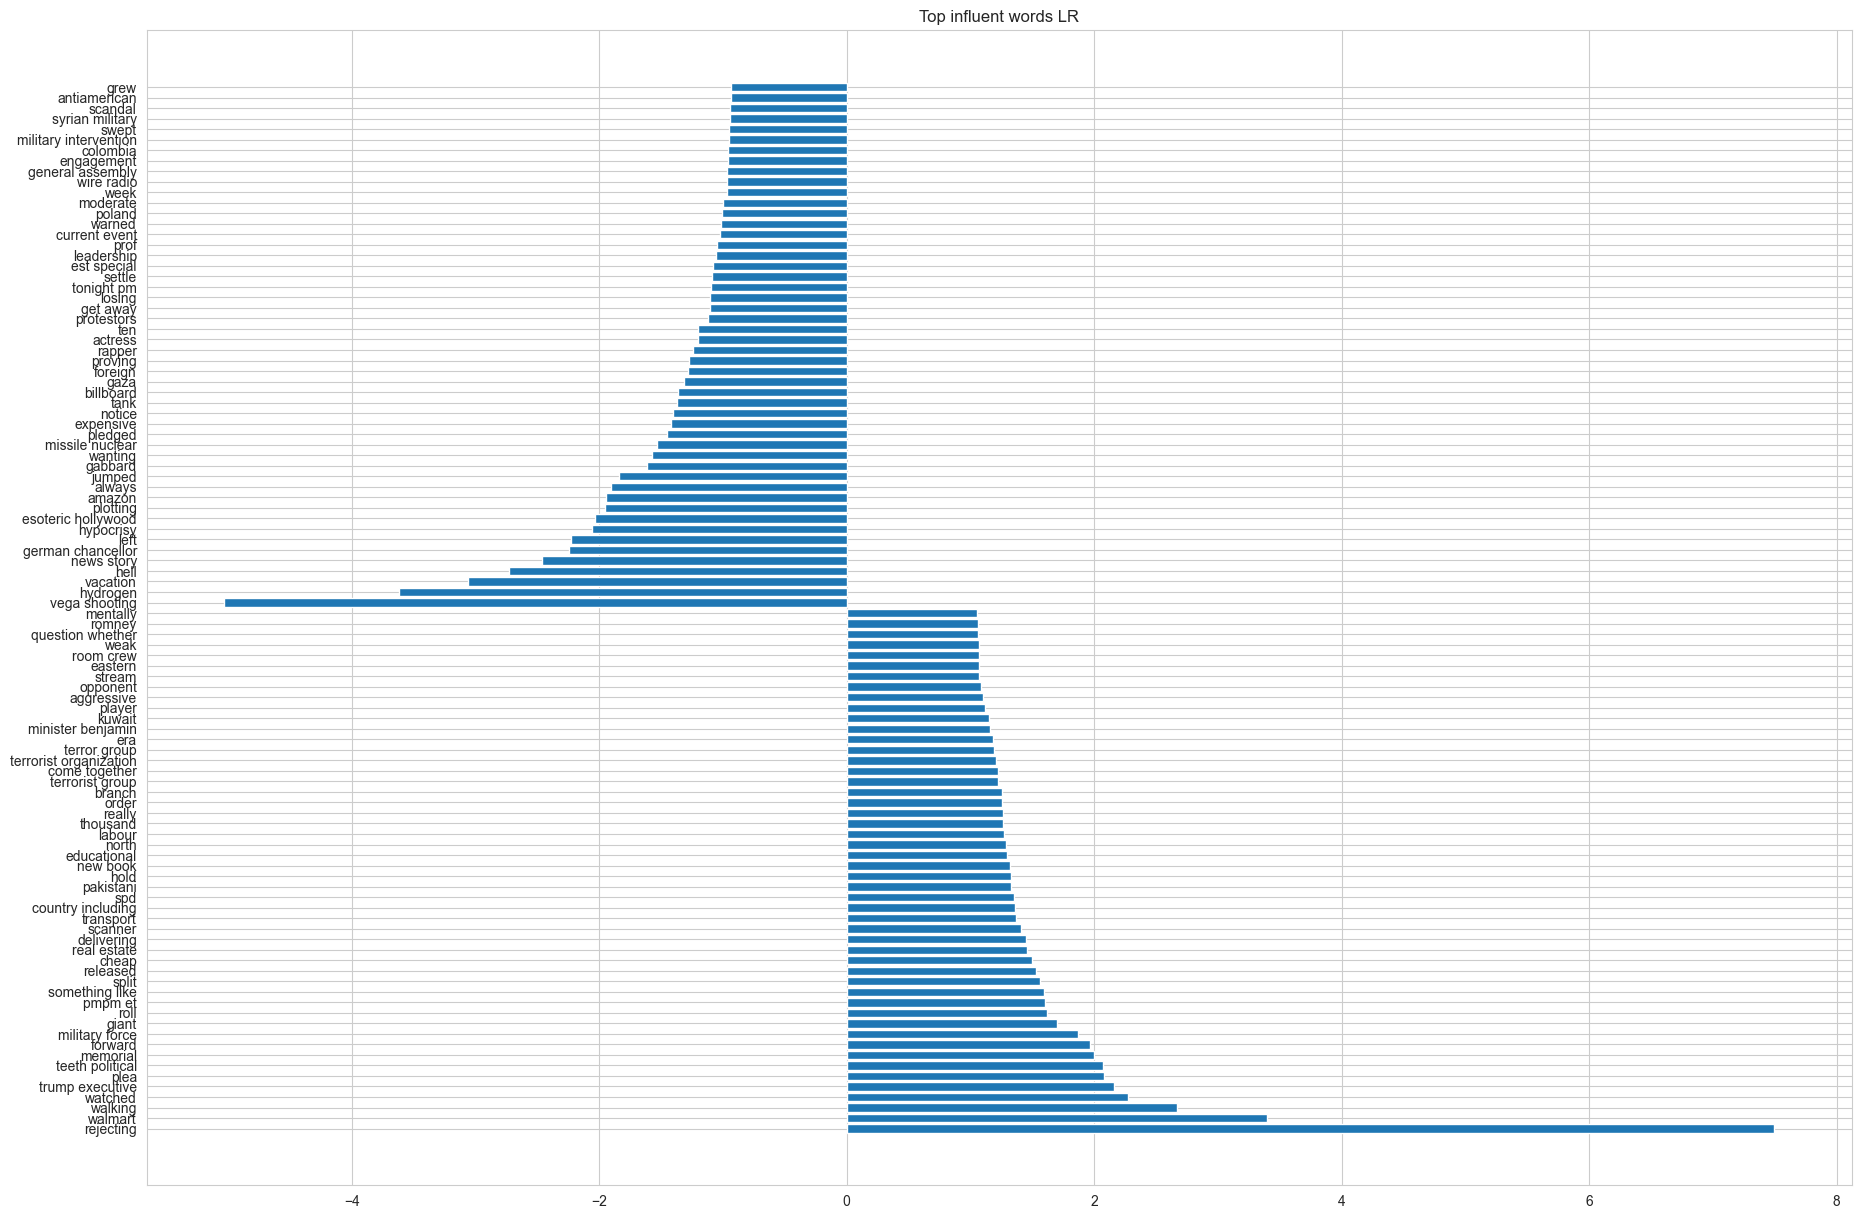

In [106]:
# Take a look at the weights of the features - Logistic regression model
feature_names = tfidf_vectorizer.get_feature_names_out()
weights = lr_model.coef_[0]

# Create the DataFrame
coef_df = pd.DataFrame({'word': feature_names, 'weight': weights})
top_words = pd.concat([
   coef_df.sort_values('weight', ascending=False).head(50), # top real
   coef_df.sort_values('weight', ascending=True).head(50) # top fake
])
plt.figure(figsize=(22, 15))
plt.barh(top_words['word'], top_words['weight'])
plt.title('Top influent words LR')
plt.show()

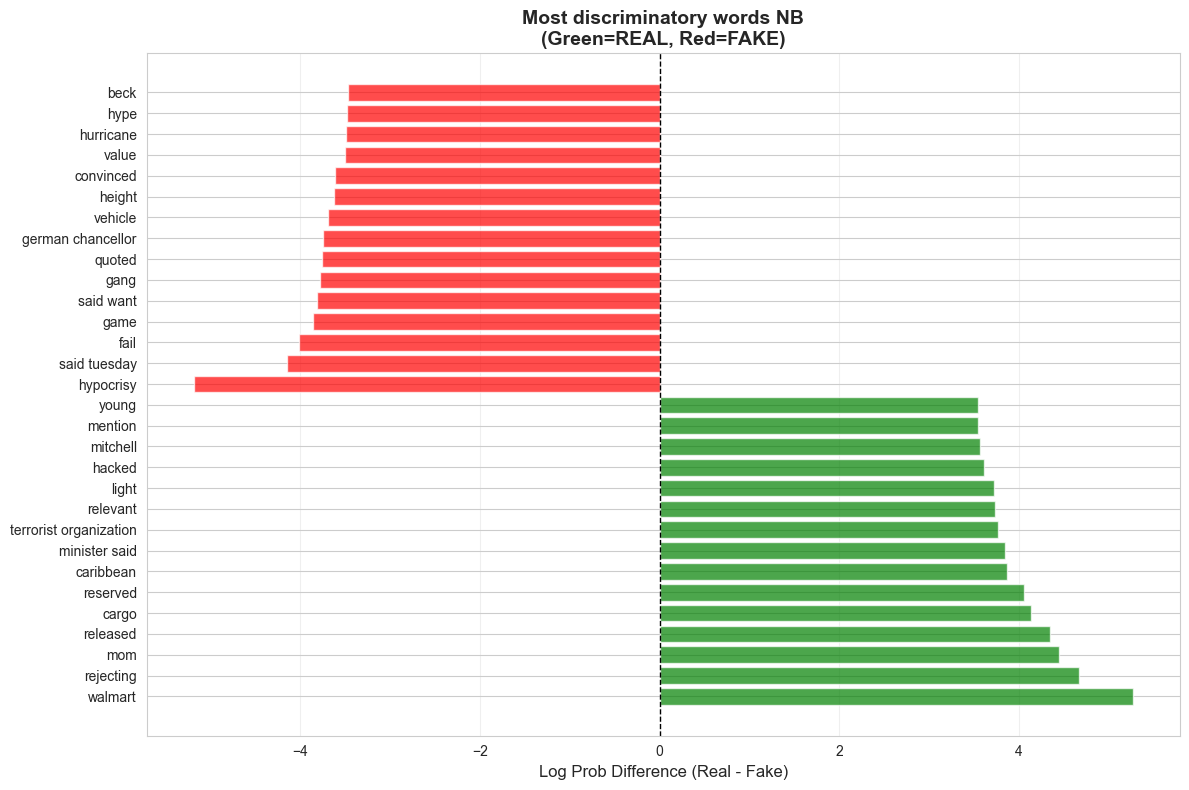

In [95]:
# Take a look at the probs of the features - MultinomialNB
# Create DF for every class
log_probs = nb_model.feature_log_prob_
real_df = pd.DataFrame({'word': feature_names, 'log_prob_real': log_probs[1]})
fake_df = pd.DataFrame({'word': feature_names, 'log_prob_fake': log_probs[0]})

comparison_df = real_df.merge(fake_df, on='word')
comparison_df['diff'] = comparison_df['log_prob_real'] - comparison_df['log_prob_fake']

top_discriminative = pd.concat([
    comparison_df.nlargest(15, 'diff'),  # Most REAL
    comparison_df.nsmallest(15, 'diff')  # Most FAKE
])

plt.figure(figsize=(12, 8))
colors = ['green' if x > 0 else 'red' for x in top_discriminative['diff']]
plt.barh(top_discriminative['word'], top_discriminative['diff'], color=colors, alpha=0.7)
plt.xlabel('Log Prob Difference (Real - Fake)', fontsize=12)
plt.title('Most discriminatory words NB\n(Green=REAL, Red=FAKE)', 
          fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [96]:
# Random forest top 15 word importance
importances = rf_model.feature_importances_
feature_names = tfidf_vectorizer.get_feature_names_out()

rf_df = pd.DataFrame({'word': feature_names, 'importance': importances})
rf_df = rf_df.sort_values('importance', ascending=False)
print(rf_df.head(15))

                        word  importance
5098               rejecting    0.122360
2893                hydrogen    0.035515
6644                vacation    0.032646
2896               hypocrisy    0.032199
6751                 walmart    0.028689
3457                    left    0.026808
6660           vega shooting    0.025162
6470         trump executive    0.019976
3771                memorial    0.019183
6784                 watched    0.015165
3280                  jumped    0.014857
4570                    plea    0.014434
6254  terrorist organization    0.013636
6757                 wanting    0.012029
6183                    tank    0.011748


Note for the future: [Permutation Importance](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py) 

## MODEL EVALUATION


MODEL EVALUATION

Logistic Regression Results:
Accuracy: 0.8772

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      3989
           1       0.88      0.87      0.88      4000

    accuracy                           0.88      7989
   macro avg       0.88      0.88      0.88      7989
weighted avg       0.88      0.88      0.88      7989


Naive Bayes Results:
Accuracy: 0.8388

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      3989
           1       0.83      0.85      0.84      4000

    accuracy                           0.84      7989
   macro avg       0.84      0.84      0.84      7989
weighted avg       0.84      0.84      0.84      7989


Random Forest Results:
Accuracy: 0.8788

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      3989
           1       0

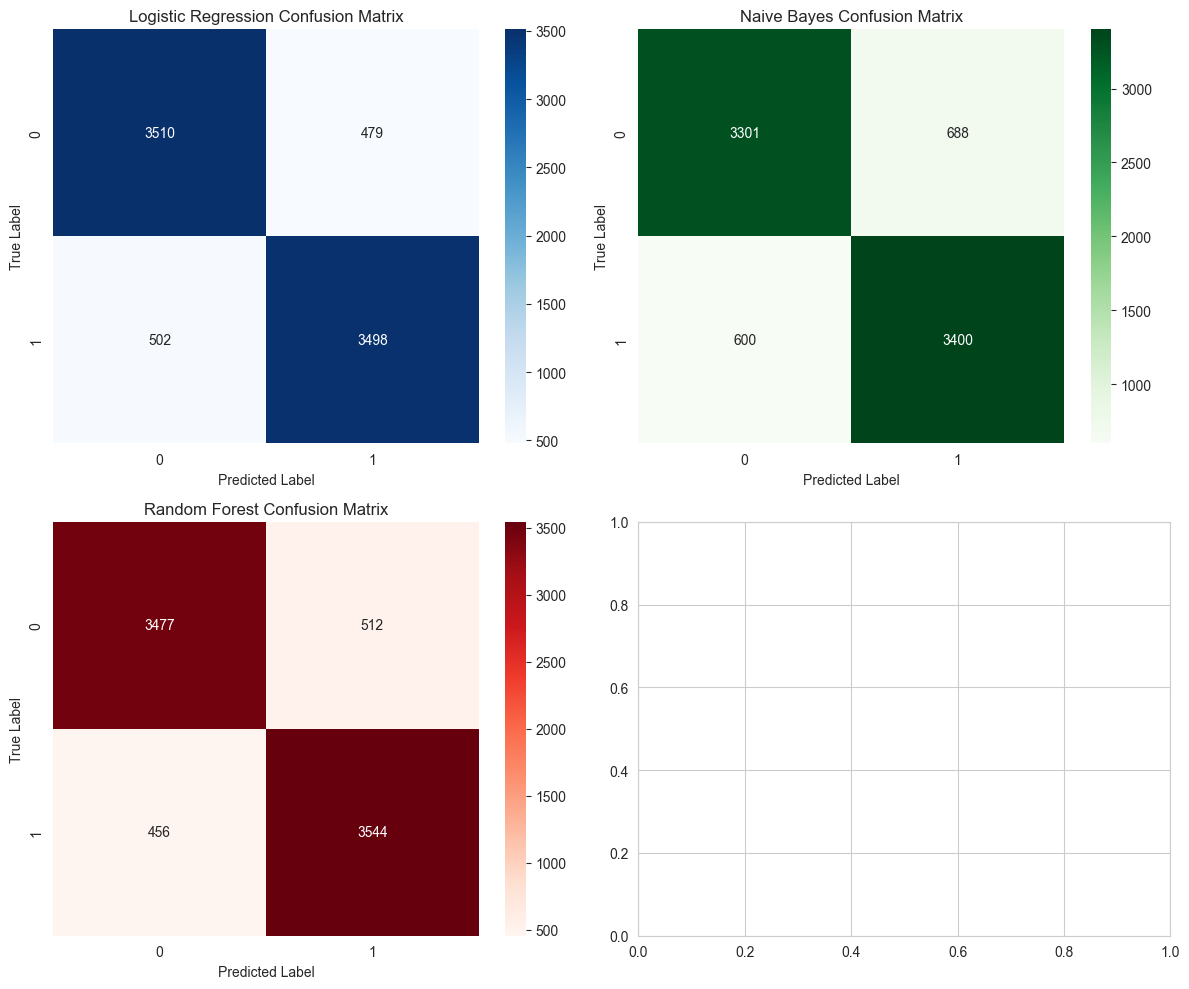

In [8]:
print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

# Logistic Regression predictions
lr_pred = lr_model.predict(X_test_tfidf)
lr_accuracy = accuracy_score(y_test, lr_pred)

print("\nLogistic Regression Results:")
print(f"Accuracy: {lr_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_pred))

# Naive Bayes predictions
nb_pred = nb_model.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_pred)

print("\nNaive Bayes Results:")
print(f"Accuracy: {nb_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, nb_pred))

# Random Forest prediction
rf_pred = rf_model.predict(X_test_tfidf)
rf_accuracy = accuracy_score(y_test, rf_pred)

print("\nRandom Forest Results:")
print(f"Accuracy: {rf_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

# Confusion Matrix visualization
# Leave one ax in blank for future models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

cm_lr = confusion_matrix(y_test, lr_pred)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0][0])
axes[0][0].set_title('Logistic Regression Confusion Matrix')
axes[0][0].set_ylabel('True Label')
axes[0][0].set_xlabel('Predicted Label')

cm_nb = confusion_matrix(y_test, nb_pred)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', ax=axes[0][1])
axes[0][1].set_title('Naive Bayes Confusion Matrix')
axes[0][1].set_ylabel('True Label')
axes[0][1].set_xlabel('Predicted Label')

cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds', ax=axes[1][0])
axes[1][0].set_title('Random Forest Confusion Matrix')
axes[1][0].set_ylabel('True Label')
axes[1][0].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

Save the models for the sake of reproducibility :)

In [11]:
import pickle
with open('../models/lr_model.pkl','wb') as f:
    pickle.dump(lr_model, f)

import pickle
with open('../models/nb_model.pkl','wb') as f:
    pickle.dump(nb_model, f)

import pickle
with open('../models/rf_model.pkl','wb') as f:
    pickle.dump(rf_model, f)

## PREDICTION ON NEW DATA

In [9]:
def predict_on_new_data(csv_path: str, tfidf_vectorizer, models: tuple, model_type: tuple = ('nb', 'lr', 'rf')):
    label_column = 'label'
    clean_txt_column = 'cleaned_text'
    df_valid = pd.read_csv(csv_path)
    df_valid[clean_txt_column] = df_valid['text'] + ' ' + df_valid['title']
    df_valid[clean_txt_column] = df_valid[clean_txt_column].apply(preprocessor.preprocess)

    # Split data
    X = df_valid[clean_txt_column]
    y = df_valid[label_column]

    # tfidf_vectorizer = TfidfVectorizer
    # Use the same tfidf from global scope
    X_tfidf = tfidf_vectorizer.fit_transform(X)
    
    # models parameter must be in this order (nb_model, lr_model, rf_model)
    for i in range(len(model_type)):
        y_pred_final = models[i].predict(X_tfidf)
        df_valid[f'label_{model_type[i]}'] = y_pred_final

    return df_valid

csv_path = '../dataset/validation_data.csv'
models = (nb_model, lr_model, rf_model)
df_valid = predict_on_new_data(csv_path, tfidf_vectorizer, models)


MAKING PREDICTIONS


We choose the Random Forest model and set the values to the `label` column. We know that the model won't work, we just stick to the accuracy.

In [17]:
df_valid['label'] = df_valid['label_rf']

In [24]:
# Drop the columns that they're not needed
df_valid.drop(['label_rf', 'label_nb', 'label_lr', 'cleaned_text'], axis=1, inplace=True)

In [ ]:
# Export to csv
df_valid.to_csv('../dataset/validation_prediction_Mauri_and_Kepa.csv', index=False)

## Temp code

In [ ]:
for_future_reference_improvements = """
1. ADVANCED PREPROCESSING:
   - Handle negations (not good → bad)
   - Spell correction
   - Emoji handling
   - Handle contractions (don't → do not)

2. BETTER FEATURES:
   - N-grams (bigrams, trigrams)
   - Word embeddings (Word2Vec, GloVe)
   - Character-level features

3. ADVANCED MODELS:
   - Deep Learning (LSTM, GRU, Transformers)
   - Ensemble methods (Random Forest, XGBoost)
   - Pre-trained models (BERT, RoBERTa, GPT)

4. HYPERPARAMETER TUNING:
   - Grid Search / Random Search
   - Cross-validation
   - Learning curves

5. HANDLE CLASS IMBALANCE:
   - SMOTE
   - Class weights
   - Undersampling/Oversampling

6. MORE EVALUATION METRICS:
   - F1-score, Precision, Recall
   - ROC-AUC curves
   - Per-class performance analysis
"""

In [ ]:
import re
from collections import Counter

def identify_leakage_words(df, top_n=50, ratio_threshold=5):
    
    fake_texts = ' '.join(df[df['label']==0]['cleaned_text'].values)
    real_texts = ' '.join(df[df['label']==1]['cleaned_text'].values)
    
    fake_words = Counter(fake_texts.lower().split())
    real_words = Counter(real_texts.lower().split())
    
    leakage_words = set()
    
    for word, count in fake_words.most_common(top_n):
        if count / (real_words.get(word, 0) + 1) > ratio_threshold:  # 10x más en fake
            leakage_words.add(word)
            print(f"FAKE marker: {word} (fake:{count}, real:{real_words.get(word, 0)})")
    
    for word, count in real_words.most_common(top_n):
        if count / (fake_words.get(word, 0) + 1) > ratio_threshold:  # 10x más en real
            leakage_words.add(word)
            print(f"REAL marker: {word} (real:{count}, fake:{fake_words.get(word, 0)})")
    
    return leakage_words

# Ejecutar
leakage_words = identify_leakage_words(df, top_n=250)

# Añadir a stopwords
custom_stopwords = list(leakage_words)

In [ ]:
import textstat
from textblob import TextBlob

def extract_linguistic_features(text):
    
    features = {}
    
    # 1. Complexity
    features['avg_word_length'] = np.mean([len(w) for w in text.split()])
    features['sentence_count'] = text.count('.') + text.count('!') + text.count('?')
    features['avg_sentence_length'] = len(text.split()) / max(features['sentence_count'], 1)
    
    # 2. Legilibilty
    features['flesch_reading_ease'] = textstat.flesch_reading_ease(text)
    features['flesch_kincaid_grade'] = textstat.flesch_kincaid_grade(text)
    
    # 3. Style
    features['exclamation_count'] = text.count('!')
    features['question_count'] = text.count('?')
    features['uppercase_ratio'] = sum(1 for c in text if c.isupper()) / max(len(text), 1)
    features['capital_words'] = sum(1 for w in text.split() if w.isupper() and len(w) > 2)
    
    # 4. Sentiment
    blob = TextBlob(text)
    features['polarity'] = blob.sentiment.polarity
    features['subjectivity'] = blob.sentiment.subjectivity
    
    # 5. Vocabulary
    words = text.split()
    features['unique_word_ratio'] = len(set(words)) / max(len(words), 1)
    
    return features

# Aplicar
linguistic_df = df['combined'].apply(extract_linguistic_features).apply(pd.Series)

# Combinar con TF-IDF
from scipy.sparse import hstack

X_tfidf = vectorizer.fit_transform(X_train)
X_ling = linguistic_df.loc[train_idx].values
X_combined = hstack([X_tfidf, X_ling])

# Entrenar
model.fit(X_combined, y_train)